In [2]:
import matplotlib as plt2 #need this for patches for shaded circles
import numpy as np
import matplotlib.pyplot as plt
import gizmo_analysis as gizmo 
import utilities as ut
import matplotlib.colors as colors
from matplotlib import rc #to use Latex math symbols like 'phi'
import astropy
from astropy.io import ascii
import matplotlib
import pdb
from importlib import reload
from sl_utilities import distance_functions
#pdb.set_trace()  #<--in case need to troubleshoot
import pickle
import os
from fof_analysis import fof

from sklearn.cluster import DBSCAN

import hdbscan
from mycolorpy import colorlist as mcp #my python package for colors

#########################################################################
#########################################################################
#load particle data here as you normally do to get the star information
#cut on Rxy, |z| and age
#run fof
#sind, sxcm, sycm, szcm, smtot, sgrpid, sr90, sr50, srmax =fof.find(x[si],y[si],z[si], b=b_kpc, mass=mass[si], ncut=ncut_min)
#srcm = np.sqrt(sxcm**2. + sycm**2.)

simname = 'm12i_res7100_mhdcv'
simdir = '/scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/'
snapnumber = 693

In [3]:
part = gizmo.io.Read.read_snapshots(['all'],'snapshot_index', snapnumber, simulation_name=simname, 
                                    simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)



# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 693, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_r7100/mhdcv/1Myr/fire2/output/snapdir_693/snapshot_693.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55620162 particles
    star      (id = 4): 15373067 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']
  gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'magnetic.field', 'mass', 'massfraction', 'photon.energy', 'position', 'potential', 'sfr', 'size', 'temperature', 'velocity']

* reading particles from:
    snapshot_69

In [6]:
rxyz     = part['star'].prop('host.distance.total')
#Rxy      = part['star'].prop('host.distance.cylindrical')[:,0]
x        = part['star'].prop('host.distance')[:,0]
y        = part['star'].prop('host.distance')[:,1]
z        = part['star'].prop('host.distance')[:,2] 
mass     = part['star'].prop('mass')

ids      = part['star'].prop('id')
id_child = part['star'].prop('id.child')
age      = part['star'].prop('age')


feh      = part['star'].prop('metallicity.fe')
mgh      = part['star'].prop('metallicity.mg')
cah      = part['star'].prop('metallicity.ca')
sh      = part['star'].prop('metallicity.s')
sih      = part['star'].prop('metallicity.si')
neh      = part['star'].prop('metallicity.ne')
oh      = part['star'].prop('metallicity.o')
nh      = part['star'].prop('metallicity.n')
ch      = part['star'].prop('metallicity.c')

In [7]:
#select young stars within the disk for star clusters
keep = np.where((age <= .003) & ((rxyz < 20)) & (abs(z) < 1.5))

In [8]:
#to run cluster finding on
rxyz0     = rxyz[keep]
#Rxy0      = Rxy[keep]
x0        = x[keep]
y0        = y[keep]
z0        = z[keep]
mass0     = mass[keep]


id0       = ids[keep]
id_child0 = id_child[keep]
age0      = age[keep]

feh0      = feh[keep]
mgh0=mgh[keep]
ch0=ch[keep]
nh0=nh[keep]
oh0=oh[keep]
neh0=neh[keep]
sih0=sih[keep]
sh0=sh[keep]
cah0=cah[keep]

#del part,rxyz,Rxy,x,y,z,mass,feh,mgh,ch,nh,oh,neh,sih,sh,cah,mgfe,ofe,sife,cafe,sfe,nefe,nfe,cfe,


In [9]:
#Creating a n*3 matrix for dbscan
positions=np.column_stack((x0,y0,z0))
chemistry=np.column_stack((feh0,mgh0,ch0,nh0,oh0,neh0,sih0,sh0,cah0))

# Applying DBSCAN

In [10]:
dbscan = DBSCAN(eps=0.004, min_samples=5)
labels = dbscan.fit_predict(positions)

labels_chem=dbscan.fit_predict(chemistry)

groups,n_members=np.unique(labels,return_counts=True)
dict(zip(groups,n_members))


groups_chem,n_members_chem=np.unique(labels_chem,return_counts=True)
dict(zip(groups_chem,n_members_chem))

{-1: 411,
 0: 203,
 1: 61,
 2: 6,
 3: 19,
 4: 15,
 5: 67,
 6: 13,
 7: 31,
 8: 8,
 9: 38,
 10: 8,
 11: 10,
 12: 10,
 13: 9,
 14: 36,
 15: 39,
 16: 8,
 17: 10,
 18: 18,
 19: 12,
 20: 19,
 21: 29,
 22: 5,
 23: 5,
 24: 11,
 25: 6,
 26: 13,
 27: 9,
 28: 8,
 29: 5,
 30: 4,
 31: 4,
 32: 5}

In [23]:
def get_cluster_members(labels,positions):
    cluster_dict={}
    for label in range(np.max(labels)+1):
        members_loc=np.where(labels==label)
        cluster_dict.update({label:positions[members_loc]})
    return cluster_dict

groups_pos=get_cluster_members(labels,positions)
print(len(groups_pos))
path="./"
file_name="dbscan_clusters"+str(snapnumber)+".pkl" 
#with open(path+file_name, 'wb') as output:
    # Pickle dictionary using protocol 0.
    #pickle.dump(groups, output)


4


# Comparison chem vs pos 

In [22]:
groups_chem=get_cluster_members(labels_chem,chemistry)
print(len(groups_chem))

33


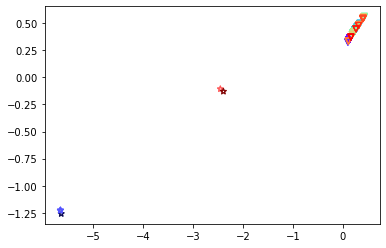

In [19]:
color_db_pos=mcp.gen_color(cmap="seismic",n=len(groups_pos))
color_db_chem=mcp.gen_color(cmap="rainbow",n=len(groups_chem))

fig1=plt.figure()

ax=fig1.add_subplot(111)


for j in range(len(groups_pos)):
    each_cluster_hdb=groups_pos[j]
    ax.scatter(each_cluster_hdb[:,0],each_cluster_hdb[:,1],facecolors='none',marker="*",edgecolors=color_db_pos[j],alpha=0.5)

for i in range(len(groups_chem)):
    each_cluster=groups_chem[i]
    ax.scatter(each_cluster[:,0],each_cluster[:,1],facecolors='none',marker="v",edgecolors=color_db_chem[i])
    


# Applying HDBSCAN

In [9]:
hdbscan_alg = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5,cluster_selection_epsilon=0.004)

# Fit the algorithm to the data
hdbscan_alg.fit(positions)

# Extract the cluster labels and probabilities for each point
labels_hdbscan = hdbscan_alg.labels_
probabilities = hdbscan_alg.probabilities_

groups_hdbscan,n_members_hdbscan=np.unique(labels_hdbscan,return_counts=True)
dict(zip(groups_hdbscan,n_members_hdbscan))

{-1: 223,
 0: 6,
 1: 6,
 2: 6,
 3: 8,
 4: 18,
 5: 9,
 6: 24,
 7: 6,
 8: 14,
 9: 15,
 10: 10,
 11: 29,
 12: 16,
 13: 21,
 14: 13,
 15: 16,
 16: 20,
 17: 7,
 18: 17,
 19: 8,
 20: 27,
 21: 12,
 22: 9,
 23: 23,
 24: 8,
 25: 9,
 26: 6,
 27: 9,
 28: 15,
 29: 5,
 30: 6,
 31: 7,
 32: 6,
 33: 7,
 34: 12,
 35: 5,
 36: 36,
 37: 6,
 38: 23,
 39: 28,
 40: 29,
 41: 9,
 42: 7,
 43: 13,
 44: 11,
 45: 6,
 46: 8,
 47: 30,
 48: 14,
 49: 11,
 50: 9,
 51: 31,
 52: 12,
 53: 15,
 54: 21,
 55: 7,
 56: 30,
 57: 9,
 58: 9,
 59: 31,
 60: 12,
 61: 22,
 62: 11,
 63: 9,
 64: 22,
 65: 16}

In [10]:
h_groups=get_cluster_members(labels_hdbscan,positions)

path="./"
file_name="hdbscan_clusters"+str(snapnumber)+".pkl" 
with open(path+file_name, 'wb') as output:
    # Pickle dictionary using protocol 0.
    pickle.dump(h_groups, output)

# Applying FOF

In [11]:
linking_length = 0.004 #4 parsec (unit here is in kpc)
ncut           = 5 #5 star particles

ind, xcm, ycm, zcm, mtot, grpid, r90, r50, rmax =fof.find(x0,y0,z0, b=linking_length, mass=mass0, ncut=ncut)
ngroup = len(mtot)
print("%d, Clusters found !!!",(ngroup))

linking length  0.004
min number particles in group  5
0.037943124771118164 seconds
number of groups 8
max number in a group 15
%d, Clusters found !!! 8


In [12]:
export_cluster={}

for grp_index in range(ngroup):  #iterate over each group
    cluster={}
    ids_in_cluster = id0[ind[grp_index]]  #these are the star particle ids in each cluster
    id_children_in_cluster = id_child0[ind[grp_index]]
    age=age0[ind[grp_index]]
    nstar = len(ids_in_cluster)
    groupid=grpid[grp_index]
    print('------------------------------------------------------------------------------------------------------------------')
    print('grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)')
    print('%s     %i     %.4f     %.4f    %.4f     %.2e     %.1f ' % (grpid[grp_index], nstar, xcm[grp_index], ycm[grp_index], zcm[grp_index], mtot[grp_index], 1000*rmax[grp_index]))
    print("age os stars in the cluster",age)
    print('ids')
    string = '[' 
    for i in ids_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)

    print('id children')
    string = '[' 
    for i in id_children_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)
    print("These are the ids printed",ids_in_cluster)
    #feh_in_cluster=feh0[ind[grp_index]]
    cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,
    "id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],
    "zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],
    "rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]]}
    export_cluster.update({groupid:cluster})

######################################################################
#######################################################################


------------------------------------------------------------------------------------------------------------------
grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)
1     15     -5.6487     -1.2267    1.0871     1.85e+05     6.0 
age os stars in the cluster [1.39232077e-04 1.39232077e-04 2.82884845e-04 8.06851215e-04
 6.32471255e-04 5.70193011e-04 4.78851884e-04 1.69955427e-04
 4.80512629e-04 5.04593438e-04 4.47297759e-04 2.52161346e-04
 4.80512629e-04 1.10496090e-03 1.55087192e-05]
ids
[39059058, 63645813, 12707128, 32560062, 44462271, 50641754, 46174319, 17439992, 64090488, 48185763, 43993944, 32522190, 44475333, 21775301, 28029180]
id children
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
These are the ids printed [39059058 63645813 12707128 32560062 44462271 50641754 46174319 17439992
 64090488 48185763 43993944 32522190 44475333 21775301 28029180]
------------------------------------------------------------------------------------------------------------------


In [13]:
path="./"
file_name="fof_clusters_"+str(snapnumber)+".pkl" 

with open(path+file_name, 'wb') as output:
    # Pickle dictionary using protocol 0.
    pickle.dump(export_cluster, output)

########################
#to test if the information was stored properly
with open(path+file_name, "rb") as fp:
    import_cluster = pickle.load(fp)

print("\n\n\nThe ids of the cluster with group id 1 is",import_cluster[1]["id"])




The ids of the cluster with group id 1 is [39059058 63645813 12707128 32560062 44462271 50641754 46174319 17439992
 64090488 48185763 43993944 32522190 44475333 21775301 28029180]


# Visualizing dbscan, hdbscan and fof clusters

In [14]:
fn1="dbscan_clusters"+str(snapnumber)+".pkl" 
fn2="hdbscan_clusters"+str(snapnumber)+".pkl" 

with open(path+fn1, "rb") as input:
  dbscan_data = pickle.load(input)

with open(path+fn2, "rb") as input:
  hdbscan_data = pickle.load(input)

fof_data=import_cluster

In [15]:
print(fof_data.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])


In [16]:
print(len(dbscan_data))
print(len(hdbscan_data))
print(len(fof_data))

4
66
8


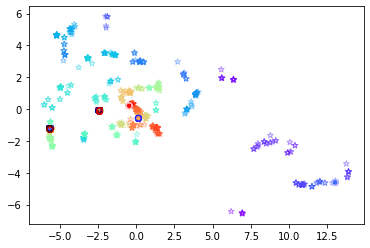

In [17]:
color_dbscan=mcp.gen_color(cmap="seismic",n=len(dbscan_data))
color_fof=mcp.gen_color(cmap="seismic",n=len(fof_data))
color_hdbscan=mcp.gen_color(cmap="rainbow",n=len(hdbscan_data))

fig1=plt.figure()

ax=fig1.add_subplot(111)


for j in range(len(hdbscan_data)):
    each_cluster_hdb=hdbscan_data[j]
    ax.scatter(each_cluster_hdb[:,0],each_cluster_hdb[:,1],facecolors='none',marker="*",edgecolors=color_hdbscan[j],alpha=0.5)

for i in range(len(dbscan_data)):
    each_cluster=dbscan_data[i]
    ax.scatter(each_cluster[:,0],each_cluster[:,1],facecolors='none',marker="v",edgecolors=color_dbscan[i])
    
    
for k in range(len(fof_data)):
    each_cluster=fof_data[k+1]
    ax.scatter(each_cluster["x"],each_cluster["y"],facecolors='none',marker="o",edgecolors=color_fof[k])
    
    
    

# Comparison between DBSCAN and FOF

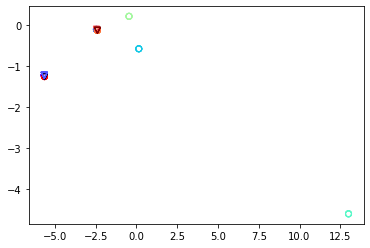

In [18]:
color_dbscan=mcp.gen_color(cmap="seismic",n=len(dbscan_data))
color_fof=mcp.gen_color(cmap="rainbow",n=len(fof_data))

fig1=plt.figure()

ax=fig1.add_subplot(111)
    
for k in range(len(fof_data)):
    each_cluster=fof_data[k+1]
    ax.scatter(each_cluster["x"],each_cluster["y"],facecolors='none',marker="o",edgecolors=color_fof[k])
    

for i in range(len(dbscan_data)):
    each_cluster=dbscan_data[i]
    ax.scatter(each_cluster[:,0],each_cluster[:,1],facecolors='none',marker="v",edgecolors=color_dbscan[i])